# Esteban Serrano's notebook
For the individual DS4D TOTA assignment

Assignment brief: Assignment 2, 30%

A self-directed analysis of real research data, marked against LO1 - Program and LO2 - Data. This will show that you are developing as a data scientist, and are able to apply your knowledge to a new, more complex dataset. Although you will be working in groups on each dataset, this assignment is handed in individually, and you should each analyse one aspect of the provided data.
* LO1 - Program: Identify and deploy strategies for writing, understanding and managing computer
programs using Python and version control.
* LO2 - Data: The ability to wrangle, analyse, learn from and visualise a range of data, in a way that
demonstrates its relevance to particular contexts of enquiry

## Intro and Reflections
+ Dataset source can be found here: https://github.com/mappingtreaties/tota/tree/master/xml

+ This notebook will be stored here: https://github.com/OllieFord/DS4D-Trade-Agreement-Project/tree/tota_esteban

+ The product of this notebook is to create a dataframe from which we can approach the data and make visualizations. I decided to split the process in two: (1)Creating a base dataframe by pulling info from metadata and (2) extracting descriptive statistics from the text data and storing it into another. The idea is to iterate as little times as possible over the source data. 

+ The xml file is structured this way: 

<treaty>
	<meta>
		metadata
	</meta>
	<body>
		<chapter number="CHAPTER 00" name="ChapterName" chapter_identifier="00">
			<article number="ARTICLE 00" name="ArticleName" article_identifier="00">articletext
			</article>
		</chapter>
	</body>
</treaty>

+ The ElementTree module from https://docs.python.org/3/library/xml.etree.elementtree.html#module-xml.etree.ElementTree was used to parse the xml file.

+ It is an attempt to flatten the dataset for easier exploration, since interacting with heirarchichal xml data is not as straightforward as tabular data. Hopefully I did not write too many bugs in the process.

+ I decided to merge 'parties' and 'parties_original'. I do this because I lack information to know which list of countries is the most relevant. This should be discussed with data holder

+ Most of the time was spent trying to get data into the right format. One of the reasons is because my research showed me that the best method for converting data must go from XML -> dict -> Series -> DataFrame. Cleaning all intermediate datatypes so a clean dataframe could be obtained(no lists with single items + no duplicates).

+ Maybe a little more time could have been spent researching on xml parsing techniques: After I had written the code for compiling the dataframe I discovered this highly recommended xml parser: https://www.crummy.com/software/BeautifulSoup/bs4/doc/ Although I am not sure how much better it would have been.

+ For example: item.findall('article_identifier') <- did not work for finding all items because it does not iterate over children of elements!

+ Since the data is in the form of a tree, the following could have been achieved with multindex to allow for multidimensional indexing: https://pandas.pydata.org/pandas-docs/stable/advanced.html

## 0. Setup

In [2]:
import re
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Search directory
directory_in_str = "xml/"
directory = os.fsencode(directory_in_str)

## 1. Base dataframe

In [4]:
# THIS CELL WILL TAKE ABOUT 2 MINUTES TO LOAD!
# List of things we are looking for in every file's metadata
cols = ["name", "status", "date_signed", "date_into_force", "date_notification", "end_implementation", "partyisocode", "composition", "region", "parties_wto", "crossregional", "language"]
df = pd.DataFrame() #temporal data frame
data = pd.DataFrame() # where final form of data will be stored
for file in os.listdir(directory): # Iterate over every file
    filename = os.fsdecode(file) # load current file
    tree = ET.parse(directory_in_str + filename) # parse tree from xml file
    root = tree.getroot() # root from xml tree
    meta_dict = {} # Create empty dict to store xml file metadata
    for item in root[0].iter(): # iterate over all elements where [0]=<meta> in tree structure 
        meta_dict.setdefault(item.tag, []).append(item.text) # Set tag as key and contents(text) as value, then append to dict, allowing duplications 
        x = pd.Series(meta_dict) # create series from dict
        target = pd.Series()
        for item in x.keys():
            if x[item][0] is None:
                s = pd.Series({item: np.nan}) #select only the first item of list with one item
                target = target.append(s) # and append to target series
            else:
                if len(x[item]) == 1: #check if list only contains one item
                    str1 = ''.join(x[item]) #Make empty strign and add (stuff)
        #            print(str1)
                    s = pd.Series({item: str1}) #select only the first item of list with one item
                    target = target.append(s) # and append to target series
                else:
                    if len(x[item]) > 1: #check if list contains more than one item
                        s = pd.Series({item:x[item]})
                        target = target.append(s) # and append to target series
    df = pd.Series.to_frame(target).T # make dataframe from series
    df = df.loc[:, df.columns.str.contains("|".join(cols))] # filter the dataframe with the hand-picked columns from 'cols'
    #here we insert words_data
    df.at[0,"partyisocode"] = list(set(df.at[0,"partyisocode"])) #remove duplicates from "partyisocode"
    df.insert(loc=0, column='file', value=filename) #insert new column with filename
    data = data.append(df) #append to final dataframe
data = data.reset_index(drop=True) # rebuild indexes

## 2. Word stats dataframe

In [5]:
#Function for counting words in text, returns words stored in list form
def list_of_words(w):
    letters_only = re.sub("[^a-zA-Z]", " ", w) #leave only letters from a-z or A-Z
    lower_case = letters_only.lower() # Make all lowercase
    words = lower_case.split() #put individual words into list
    return words

In [6]:
dfw = pd.DataFrame() # temp dataframe for storing data for individual files
words_data = pd.DataFrame() # where word stats data will be stored
for file in os.listdir(directory): # Iterate over every file
    filename = os.fsdecode(file) # load current file
    tree = ET.parse(directory_in_str + filename) # parse tree from xml file
    root = tree.getroot() # root from xml tree
    
    #Count number of articles per document
    article_count = 0
    for item in root[1].iter():
        if "article_identifier" in item.attrib.keys():
            article_count += 1
    
    chapter_count = len(root[1].findall('chapter')) #find number of chapters per document
    #print(f"{filename}: {chapter_count} {article_count}")
    
    # get string with all text in the document(does not include chapter and article titles)
    text = ""
    word_count = 0
    for item in root[1].iter():
        word_count += len(list_of_words(item.text)) # count individual words

    # find average word count per article
    l = [] # make empty list for storing length of individual articles
    for item in root[1].iter():
        l.append(len(list_of_words(item.text)))
    l = list(filter((0).__ne__, l)) #filter all zeroes that come from items having 0 words like chapters, where only articles whithin the chapters are the containters of words. There cant be articles with zero words
    WxA = sum(l)/len(l) # get average of words per article
    
    counters = [(chapter_count, article_count, word_count, WxA)]
    col_names = ['chapter_count', 'article_count', 'word_count', 'average_WxA']
    dfw = pd.DataFrame.from_records(counters, columns=col_names)
    words_data = words_data.append(dfw)
    
#words_data.insert(loc=0, column='file', value=filename) #insert new column with filename

words_data = words_data.reset_index(drop=True) # rebuild indexes

In [7]:
# join the two datasets
big_data = pd.concat([data, words_data], axis=1) # the author of this notebook adheres to the "no pun intended" varialbe-naming philosophy
big_data

file                                               name    status  \
0    pta_218.xml                    EC - Greece Additional Protocol  Inactive   
1    pta_230.xml                    EC - Portugal Agreement of 1972  Inactive   
2    pta_224.xml                 EC - Lebanon Cooperation Agreement  Inactive   
3    pta_378.xml                               Mauritius - Pakistan  In Force   
4    pta_344.xml                                     Turkey - Chile  In Force   
5    pta_422.xml                    Russian Federation - Azerbaijan  In Force   
6    pta_436.xml                       New Zealand - Chinese Taipei  In Force   
7    pta_350.xml                            Iceland - Faroe Islands  In Force   
8    pta_387.xml                                      Canada - Peru  In Force   
9    pta_393.xml                                   Chile - Viet Nam  In Force   
10   pta_146.xml                             Canada - Rep. of Korea  In Force   
11   pta_152.xml                                      ASEAN - Japan  In Force   
12    pta_22.xml                         Mexico - Northern Triangle  Inactive   
13   pta_185.xml                                  Bulgaria - Turkey  Inactive   
14   pta_191.xml  Central European Free Trade Agreement (CEFTA) ...  Inactive   
15    pta_36.xml                               Thailand - Australia  In Force   
16   pta_190.xml  Central European Free Trade Agreement (CEFTA) ...  Inactive   
17    pta_37.xml                                     US - Australia  In Force   
18    pta_23.xml  Dominican Republic - Central America - United ...  In Force   
19   pta_184.xml                                Bulgaria - Slovenia  Inactive   
20   pta_153.xml                                    EFTA - Colombia  In Force   
21   pta_147.xml                         ASEAN - Korea, Republic of  In Force   
22   pta_392.xml                                       EU - Ukraine  In Force   
23   pta_386.xml                         Nicaragua - Chinese Taipei  In Force   
24   pta_437.xml                                 El Salvador - Cuba  In Force   
25   pta_351.xml                          Brunei Darussalam - Japan  In Force   
26   pta_345.xml                                   India - Malaysia  In Force   
27   pta_423.xml                    Russian Federation - Kazakhstan  Inactive   
28   pta_379.xml                        Rep. of Korea - New Zealand  In Force   
29   pta_225.xml                                     EC - Lithuania  Inactive   
..           ...                                                ...       ...   
420  pta_362.xml                       Ukraine - Russian Federation  Inactive   
421  pta_404.xml                         Korea, Republic of - India  In Force   
422  pta_410.xml  Colombia - Northern Triangle (El Salvador, Gua...  In Force   
423  pta_376.xml                                Switzerland - China  In Force   
424  pta_216.xml              EC - Faeroe Islands Agreement of 1992  Inactive   
425  pta_202.xml      Czech Republic - Romania Free Trade Agreement  Inactive   
426  pta_214.xml                   EC - Egypt Cooperation Agreement  Inactive   
427  pta_200.xml                            Czech Republic - Latvia  Inactive   
428  pta_228.xml                       EC - Poland Europe Agreement  Inactive   
429  pta_406.xml                                  Costa Rica - Peru  In Force   
430  pta_360.xml                               Ukraine - Uzbekistan  In Force   
431  pta_374.xml                                      Chile - India  In Force   
432  pta_412.xml                                       Japan - Peru  In Force   
433  pta_348.xml                                     India - Bhutan  In Force   
434  pta_162.xml           South Asian Free Trade Agreement (SAFTA)  In Force   
435  pta_176.xml                  Bulgaria - Bosnia and Herzegovina  Inactive   
436   pta_12.xml                                     Turkey - Syria  In Force   
437  pta_189.xml      Central European Free

## Visualizations

In [8]:
#Function for smoothing things
def rollSmooth(d,w):
    roll = d.rolling(window=w, center=True) #rolling window
    roll_mean = roll.mean() #average of rolling
    smoothed_data = roll_mean.fillna(method='bfill') #backward fill with nan values
    smoothed_data = smoothed_data.fillna(method='ffill') #forward fill with nan values
    return smoothed_data

### Length of treaty v/s time
+ From the graph we can see a clear growth in the size of treaties over time.
+ A red line with rolling average smoothing function was provided

In [9]:
fig, axs = plt.subplots(figsize=(20, 10))
plt.locator_params(nbins=10, axis='y')
axs.plot(big_data.sort_values(by=['date_signed'])['date_signed'], big_data.sort_values(by=['date_signed'])['word_count'],'-k')
axs.plot(big_data.sort_values(by=['date_signed'])['date_signed'], rollSmooth(big_data.sort_values(by=['date_signed'])['word_count'],20),'-r')
axs.set_ylabel('Word count')
axs.set_xlabel('Dates')
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
axs.xaxis.set_major_locator(xloc)
plt.xticks(rotation=90)

(array([-30.,   0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270.,
        300., 330., 360., 390., 420., 450.]),
 <a list of 17 Text xticklabel objects>)

### Amount of treaties signed per year
+ Althought the length of treaties is increasing, there rate at which treaties have been signed is decreasing

In [10]:
# Get list with datetime objects from date_signed column
date_signed = []
for item in big_data['date_signed']:
    date_signed.append(datetime.strptime(item, '%Y-%m-%d'))

In [11]:
# Get list with years
years = []
for item in date_signed:
    years.append(item.year)
years = list(set(years)) # remove duplicates from list

In [12]:
# Get amount of treaties signed per year
signed_per_year = []
for item in years:
    c = 0
    for x in big_data["date_signed"]:
        if str(item) in x:
            c += 1
    signed_per_year.append(c)    

(array([1944. , 1945.5, 1947. , 1948.5, 1950. , 1951.5, 1953. , 1954.5,
        1956. , 1957.5, 1959. , 1960.5, 1962. , 1963.5, 1965. , 1966.5,
        1968. , 1969.5, 1971. , 1972.5, 1974. , 1975.5, 1977. , 1978.5,
        1980. , 1981.5, 1983. , 1984.5, 1986. , 1987.5, 1989. , 1990.5,
        1992. , 1993.5, 1995. , 1996.5, 1998. , 1999.5, 2001. , 2002.5,
        2004. , 2005.5, 2007. , 2008.5, 2010. , 2011.5, 2013. , 2014.5,
        2016. , 2017.5, 2019. , 2020.5]),
 <a list of 52 Text xticklabel objects>)

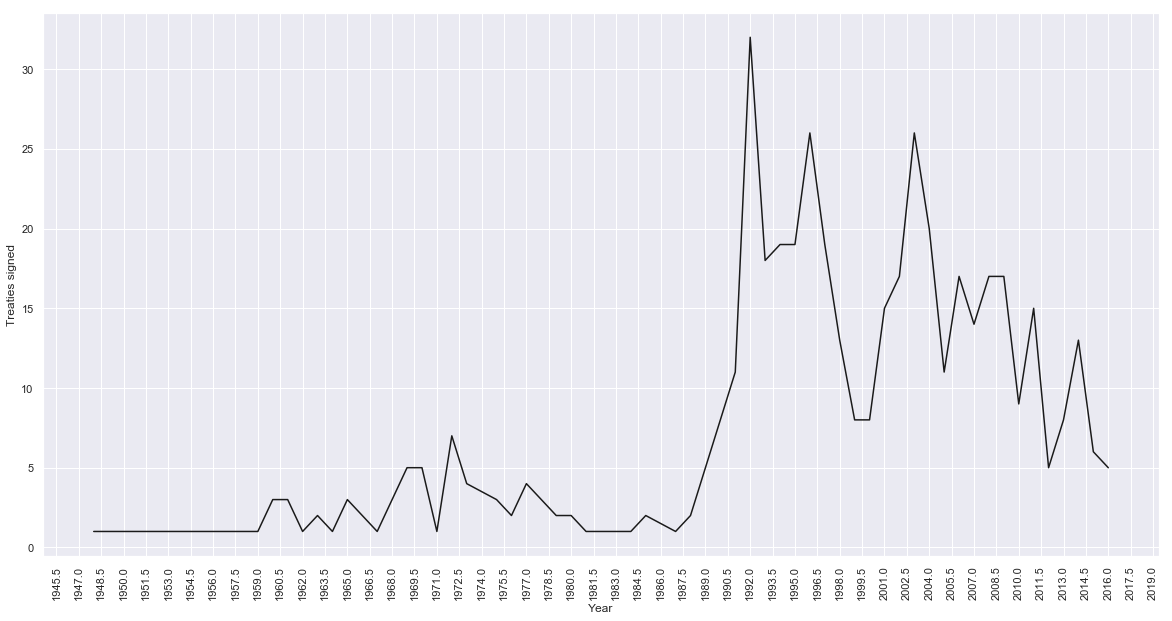

In [13]:
# plot data
fig, axs = plt.subplots(figsize=(20, 10))
plt.locator_params(nbins=10, axis='y')
axs.plot(years ,signed_per_year ,'-k')
axs.set_ylabel('Treaties signed')
axs.set_xlabel('Year')
max_xticks = len(years)
xloc = plt.MaxNLocator(max_xticks)
axs.xaxis.set_major_locator(xloc)
plt.xticks(rotation=90)

### Amount of parties vs word count correlation
+ There is no apparent correlation

In [14]:
size_of_party = []
for item in big_data['partyisocode']:
    size_of_party.append(len(item))

    w_count = big_data['word_count'].tolist()
df = pd.DataFrame()
df = pd.DataFrame.from_records([w_count], columns=size_of_party).T
df = df.sort_index(0) # rebuild indexes

In [16]:
# plot data
fig, axs = plt.subplots(figsize=(10, 10))
plt.locator_params(nbins=10, axis='y')
axs.scatter(df.index.values ,df[0])
axs.set_ylabel('Length of document')
axs.set_xlabel('Amount of parties')

Text(0.5,0,'Amount of parties')

### Amount of parties vs chapter count correlation
+ There is no apparent correlation

In [17]:
c_count = big_data['chapter_count'].tolist()
df = pd.DataFrame()
df = pd.DataFrame.from_records([c_count], columns=size_of_party).T
df = df.sort_index(0) # rebuild indexes

Text(0.5,0,'Amount of parties')

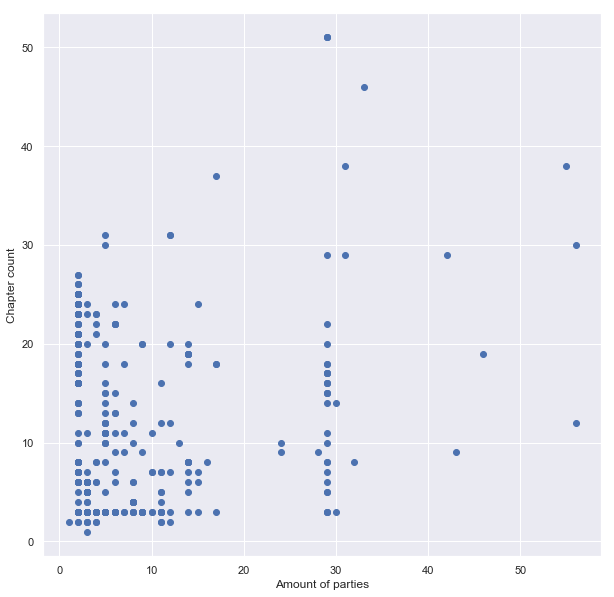

In [18]:
# plot data
fig, axs = plt.subplots(figsize=(10, 10))
plt.locator_params(nbins=10, axis='y')
axs.scatter(df.index.values ,df[0])
axs.set_ylabel('Chapter count')
axs.set_xlabel('Amount of parties')